In [1]:
!pip install -qU "semantic-router[local]"


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
GROQ_API_KEY = "your-api-key"

In [3]:
from llama_index.agent.openai import OpenAIAgent
from llama_index.llms.groq import Groq
from llama_index.core.tools import FunctionTool
from semantic_router import Route
from semantic_router.encoders import HuggingFaceEncoder
from semantic_router.layer import RouteLayer
from IPython.display import Markdown
from ema_workbench import load_results
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as sch
from sklearn_extra.cluster import KMedoids
import pickle
import seaborn as sns

/home/ana/Documents/Proyectos/microminer-eval/.venv/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


In [4]:
class DecompositionSpace:
    def __init__(self, project_path, project_name):
        model_filename = f"{project_path}/{project_name}_128scenarios_nopolicies_sobol" #.tar.gz'
        experiments_df, outcomes = load_results(model_filename+ '.tar.gz')
        experiments_df['beta'] = 100 - experiments_df['alpha']
        self.outcomes = pd.DataFrame(outcomes)
        self.experiments = experiments_df
        with open(model_filename+'_model.pkl', 'rb') as input:
            self.uncertainties_problem = pickle.load(input)
        with open(model_filename+'_partitions.pkl', 'rb') as input:
            self.partitions = pickle.load(input)
        similarity_filename = f"{project_path}/{project_name}_omega_scores.csv"
        self.partitions_distance = 1 - pd.read_csv(similarity_filename, index_col=0)
        stable_solutions_filename = f"{project_path}/{project_name}_stable_solutions.pkl"
        with open(stable_solutions_filename, 'rb') as f:
             self.stable_solutions = pickle.load(f)
             self.other_labels = self.stable_solutions.keys()
        mds = MDS(dissimilarity='precomputed', random_state=0)
        self.embeddings_2d_partitions = mds.fit_transform(self.partitions_distance)
        partition_labels_2d, _, silhouette = self.run_agglomerative(self.embeddings_2d_partitions, k=5, threshold=None, 
                                                       show_dendogram=True, normalize=True, n_pca=2)
        self.partition_labels = partition_labels_2d

    def run_agglomerative(self, df, k, threshold=200, n_pca=None, normalize=False, show_dendogram=False, archstructure=None):    
      if normalize:
        sample = StandardScaler().fit_transform(df)
      else:
        sample = df.values
    
      if n_pca is not None:
        pca = PCA(n_components=n_pca)
        sample_pca = sample
        model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward',
                                        connectivity=archstructure, distance_threshold=threshold)
        model.fit(sample_pca)
        X = sample_pca
      else:
        model = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='single',
                                      connectivity=archstructure, distance_threshold=threshold)
        model.fit(sample)
      labels = model.labels_
      fixed_labels = np.where(model.labels_ < 0, 0, model.labels_)
      classes = set(fixed_labels)
      if len(classes) > 1:
        if n_pca is not None:
          silhouette = metrics.silhouette_score(sample_pca, fixed_labels)
        else:
          silhouette = metrics.silhouette_score(sample, fixed_labels)
      else:
        silhouette = 0.0    
      return fixed_labels, model, silhouette

    def get_decompositions_by_metric(self, metric: str, k: int, asc: bool) -> list:
        return self.outcomes.sort_values(by=[metric], ascending=[asc]).head(k)

    def get_xy_coordinates(self, labels, embeddings_2d, distance_df):
        xy_coordinates = []
        for lb in labels:
            idx = list(distance_df.columns).index(lb)
            xy_coordinates.append(embeddings_2d[idx])
        return xy_coordinates

    def get_decomposition_space(self, labels: [] = []) -> plt.plot: 
        fig = plt.figure(figsize=(8,6))
        df = pd.DataFrame(self.embeddings_2d_partitions, columns=['x', 'y'])
        df['cluster'] = self.partition_labels 
        ax = sns.scatterplot(data=df, x="x", y="y", hue="cluster", palette="tab10", alpha=0.3, legend='full', sizes=(20, 200))
        ax.set(xlabel=None)
        ax.set(ylabel=None)
        if len(labels) > 0:
            medoids = np.array(self.get_xy_coordinates(labels, self.embeddings_2d_partitions, self.partitions_distance))
            ax.plot(medoids[:,0], medoids[:,1], 'X', markersize=9, alpha=0.7, color='black')
            for idx, lb in enumerate(labels):
                    ax.annotate(lb, (medoids[idx,0], medoids[idx,1]))
            
        plt.grid(False)
        return plt

    #TODO translate/map quality attributes to metrics

In [5]:
class SemanticLayer:
    SYSTEM_PROMPT = """Your are an expert software architect that assists users to explore and understand a de.
        You have a deep understanding of monolith to microservices migration and microservices quality metrics.
        Your role is to help users to understand the decomposition space to pick the most suitable microservices decomposition according to the user need.
        """

    def __init__(self, decomposition_space=None) -> None:
        self.llm = Groq(model="llama3-8b-8192", api_key=GROQ_API_KEY, base_url="https://api.groq.com/openai/v1")
        self.agent = None
        self.intent_detector = None
        self.decomposition_space = decomposition_space


    def show_decomposition_space(self) -> plt.plot:
        """ Gets the decomposition space (plot)

        Returns:
            plt.plot: The plot of the decomposition space
        """
        return self.decomposition_space.get_decomposition_space().show()

    def get_decomposition_by_metric(self, k: int, metric: str, asc: bool) -> pd.DataFrame:
        """ Gets the K decompositions matching a metric condition

          Args:
            k (int): The number of decompositions to retrieve.
            metric (str): The metric to match the decompositions against.
            asc (bool): Whether to obtain the decompositions that match a metric higher or lower
    
        Returns:
            pd.DataFrame: The K decompositions ordered by asc param against the metric passed as parameter.
        """
        return self.decomposition_space.get_decompositions_by_metric(metric, k, asc)

    def show_decomposition_in_space(self, k: int, metric: str, asc: bool) -> plt.plot:
        """ Show in the decomposition space (plot) the desired K decompositions matching a metric condition

        Args:
            k (int): The number of decompositions to show.
            metric (str): The metric to match the decompositions against.
            asc (bool): Whether to show the decompositions that match a metric higher or lower
    

        Returns:
            plt.plot: The plot of the decomposition space with the decompositions found
        """
        decompositions = self.decomposition_space.get_decompositions_by_metric(metric, k, asc)
        indexes = decompositions.index.values
        labels = []
        for index in indexes:
            value = self.decomposition_space.experiments.iloc[index]
            labels.append(f"resolution_{value['resolution']}_alpha_{value['alpha']}_mfuzzy_{value['mfuzzy']}_mthreshold_{value['microservice_threshold']}")
        return self.decomposition_space.get_decomposition_space(labels).show()

   
    def _get_tools(self):
        return [ # All the functions that the agent can execute
            FunctionTool.from_defaults(fn=self.show_decomposition_space, return_direct=True),
            FunctionTool.from_defaults(fn=self.get_decomposition_by_metric, return_direct=True),
            FunctionTool.from_defaults(fn=self.show_decomposition_in_space, return_direct=True),
        ]

    def _configure_routes():
        return [
            Route(
                name="show_decomposition_space",
                utterances=[
                    "Which decompositions are generated?",
                    "Show me the decomposition space graphically",
                    "Get all decompositions graphically",
                    "Show me all decompositions",
                    "Show the decomposition space",
                    "Show the decomposition space graphically"
                ],
                description="Show the decomposition space graphically."
            ),
            Route(
                name="get_decomposition_by_metric",
                utterances=[
                    "Get the X decompositions with less Y",
                    "Get me X decompositions with more Y",
                    "Which is the decomposition with more X?",
                    "Which is the decomposition with less X?",
                    "Which is the decomposition of highest X?",
                    "Which is the decomposition of lowest X?",
                ],
                description="Get the K decompositions that match a preferring metric."
            ),
            Route(
                name="show_decomposition_in_space",
                utterances=[
                    "Show me the decomposition with more X",
                    "Get a plot of the decomposition X",
                    "Show me the decomposition with more X graphically",
                    "Show me the decomposition with lowest X graphically",
                    "Show me the decomposition with highest X graphically",
                    "Show me the decomposition of lowest X graphically",
                    "Show me the decomposition of highest X graphically",
                ],
                description="Show the K decompositions that match a preferring metric in the decomposition space."
            )
        ]

    def clear_memory(self):
        self.agent.reset()

    def chat(self, question):

        if self.agent is None: # Kind of Singleton
            enable_gpu=True
            tools = self._get_tools()
            self.agent = OpenAIAgent.from_tools(tools, llm=self.llm, system_prompt=SemanticLayer.SYSTEM_PROMPT, verbose=True)
            encoder = HuggingFaceEncoder()
            self.intent_detector = RouteLayer(encoder=encoder, routes=SemanticLayer._configure_routes(), llm=self.llm)

        intent  = self.intent_detector(question)
        print("Intent detected:", intent.name)

        if intent.name is None:
            msg = "I'm sorry, I did not understand your question or I'm no able to answer it. Please try again..."
            return display(Markdown(f"<b>{msg}</b>"))

        function_name = "\nTry to execute tool "+intent.name if (intent.name is not None) and (intent.name != 'misc') else ""
        response = self.agent.chat(question+function_name)

        if response.sources is None or len(response.sources) == 0:
            return display(Markdown(f"<b>{response.response}</b>"))

        obj = response.sources[0].raw_output

        show_op = getattr(obj, "show", None)
        if callable(show_op):
            msg =  "This is a graphical representation of the results for your question."
            display(Markdown(f"<b>{msg}</b>"))
            show_op()
            return None

        return obj

In [6]:
decomposition_space = DecompositionSpace("../jpetstore", "jpetstore")

/home/ana/Documents/Proyectos/microminer-eval/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ana/Documents/Proyectos/microminer-eval/.venv/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [7]:
layer = SemanticLayer(decomposition_space)

In [8]:
layer.chat("Get the 10 decompositions with higher density")

Intent detected: get_decomposition_by_metric
Added user message to memory: Get the 10 decompositions with higher density
Try to execute tool get_decomposition_by_metric
=== Calling Function ===
Calling function: get_decomposition_by_metric with args: {"k":10,"metric":"density","asc":true}
Got output:       n_partitions  modularity    ned   density  noise_classes
45               9   -0.005252  0.682  0.859027             17
21               9   -0.006433  0.598  0.868000             17
26               7   -0.007895  0.849  0.980822             17
857              7   -0.008278  0.620  0.993176             17
821              8   -0.004839  0.783  1.049847             17
226              9   -0.006553  0.702  1.049867             17
224              8   -0.006645  0.706  1.056979             17
1043             9   -0.007345  0.695  1.090393             17
727              7   -0.008501  0.600  1.095644             17
1018             8   -0.006335  0.670  1.097129             17



,n_partitions,modularity,ned,density,noise_classes
45,9,-0.005252,0.682,0.859027,17
21,9,-0.006433,0.598,0.868000,17
26,7,-0.007895,0.849,0.980822,17
857,7,-0.008278,0.620,0.993176,17
821,8,-0.004839,0.783,1.049847,17
226,9,-0.006553,0.702,1.049867,17
224,8,-0.006645,0.706,1.056979,17
1043,9,-0.007345,0.695,1.090393,17
727,7,-0.008501,0.600,1.095644,17
1018,8,-0.006335,0.670,1.097129,17


In [9]:
layer.chat("Get the decomposition with lowest ned")

Intent detected: get_decomposition_by_metric
Added user message to memory: Get the decomposition with lowest ned
Try to execute tool get_decomposition_by_metric
=== Calling Function ===
Calling function: get_decomposition_by_metric with args: {"k":1,"metric":"ned","asc":false}
Got output:      n_partitions  modularity  ned   density  noise_classes
640             7   -0.004216  1.0  1.288805             17



,n_partitions,modularity,ned,density,noise_classes
640,7,-0.004216,1.0,1.288805,17


In [10]:
layer.chat("Which is the decomposition of highest modularity?") 

Intent detected: get_decomposition_by_metric
Added user message to memory: Which is the decomposition of highest modularity?
Try to execute tool get_decomposition_by_metric
=== Calling Function ===
Calling function: get_decomposition_by_metric with args: {"k":1,"metric":"modularity","asc":true}
Got output:      n_partitions  modularity    ned  density  noise_classes
283             8   -0.075644  0.804  7.54982             17



,n_partitions,modularity,ned,density,noise_classes
283,8,-0.075644,0.804,7.54982,17


Intent detected: show_decomposition_in_space
Added user message to memory: Show me the decomposition with highest density graphically
Try to execute tool show_decomposition_in_space
=== Calling Function ===
Calling function: show_decomposition_in_space with args: {"k":1,"metric":"density","asc":true}


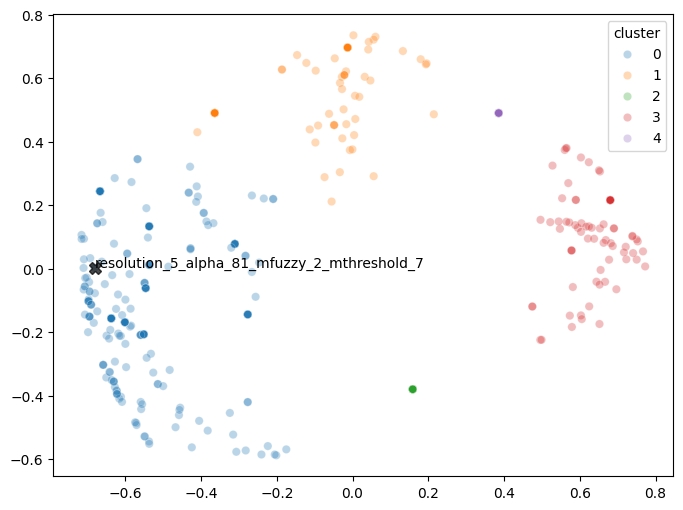

Got output: None



In [11]:
layer.chat("Show me the decomposition with highest density graphically") 

Intent detected: show_decomposition_in_space
Added user message to memory: Show me the 10 decompositions with lowest modularity graphically
Try to execute tool show_decomposition_in_space
=== Calling Function ===
Calling function: show_decomposition_in_space with args: {"k":10,"metric":"modularity","asc":false}


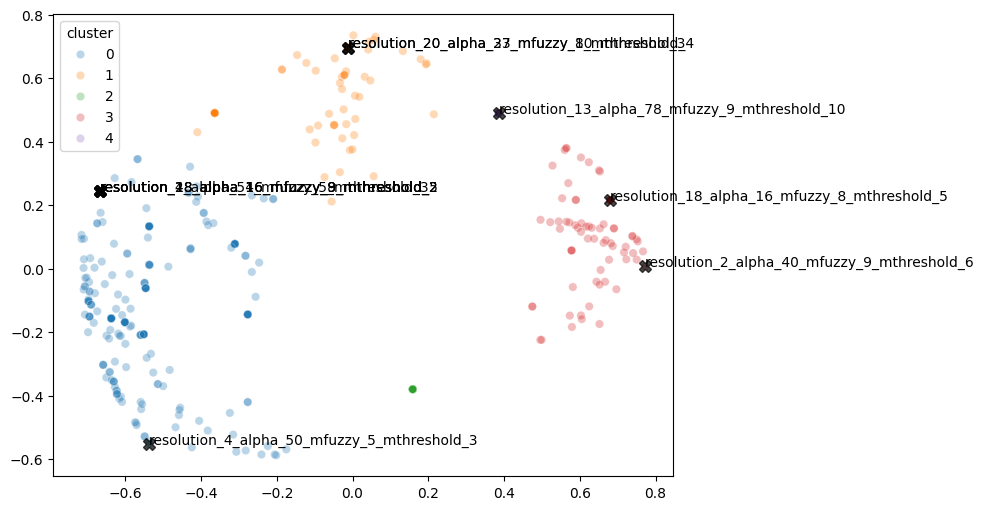

Got output: None



In [12]:
layer.chat("Show me the 10 decompositions with lowest modularity graphically") 